In [49]:
# Install the latest Tensorflow version.
!pip3 install --quiet "tensorflow>=1.7"
# Install TF-Hub.
!pip3 install --quiet tensorflow-hub
!pip3 install --quiet seaborn
!pip install python-Levenshtein




In [10]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

In [11]:
#import universal sentence encoder 
module_url = "https://tfhub.dev/google/universal-sentence-encoder/2" #@param ["https://tfhub.dev/google/universal-sentence-encoder/2", "https://tfhub.dev/google/universal-sentence-encoder-large/3"]
embed = hub.Module(module_url)


INFO:tensorflow:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/2'.
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 58.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 98.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 148.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 178.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 218.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 268.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 318.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 358.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 388.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-enc

In [30]:
Path='/home/nkatebi/deid2/codes/all'
import os
filenames =os.listdir(Path) 
#print(filenames)
files = {}
 
for filename in filenames:
    with open('/home/nkatebi/deid2/codes/all/'+filename, "r") as file:
        if filename in files:
            continue
        files[filename] = file.read()
messages=[] 
label=[]
for filename, text in files.items():
    text=re.sub('\n',' ',text)
    text=re.sub('#',' ',text)

    messages.append(text)
    label.append(filename)
#print(messages)


In [31]:
# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

with tf.Session() as session:
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  message_embeddings = session.run(embed(messages))

  for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
    #print("Message: {}".format(messages[i]))
    print("Embedding size: {}".format(len(message_embedding)))
    message_embedding_snippet = ", ".join(
        (str(x) for x in message_embedding[:3]))
    print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

Embedding size: 512
Embedding: [-0.04442385584115982, -0.048729393631219864, 0.050149187445640564, ...]

Embedding size: 512
Embedding: [-0.02818605862557888, -0.05266788229346275, 0.05380374938249588, ...]

Embedding size: 512
Embedding: [-0.050901371985673904, -0.03573325648903847, 0.05349111929535866, ...]



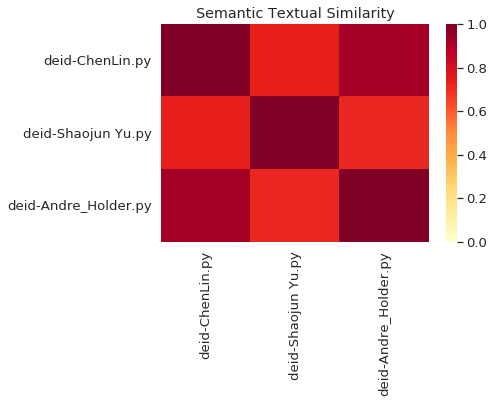

In [32]:

def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

def run_and_plot(session_, input_tensor_, messages_,label, encoding_tensor):
  message_embeddings_ = session_.run(
      encoding_tensor, feed_dict={input_tensor_: messages_})
  plot_similarity(label, message_embeddings_, 90)
        
similarity_input_placeholder = tf.placeholder(tf.string, shape=(None))
similarity_message_encodings = embed(similarity_input_placeholder)
with tf.Session() as session:
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  run_and_plot(session, similarity_input_placeholder, messages,label,
               similarity_message_encodings)

In [38]:
# Similarity metrics
# comparing codes 
#!pip install python-Levenshtein

import Levenshtein as L
n=len(messages)
Jaro = [0] *n
for i in range(n):
    Jaro[i] = [0] * n
    
abs_dist = [0] *n
for i in range(n):
    abs_dist[i] = [0] * n 
    
#Hamming = [0] *n
#for i in range(n):
#    Hamming[i] = [0] * n

jaro_winkler = [0] *n
for i in range(n):
    jaro_winkler[i] = [0] * n

    ratio = [0] *n
for i in range(n):
    ratio[i] = [0] * n
    
    
    
    
for i in range(0,len(messages)):
    for j in range(0,len(messages)):
        Jaro[i][j]=L.jaro(messages[i],messages[j])
        abs_dist[i][j]=L.distance(messages[i],messages[j])
        #Hamming[i][j]=L.Hamming(messages[i],messages[j])
        jaro_winkler[i][j]=L.jaro_winkler(messages[i],messages[j])
        ratio[i][j]=L.ratio(messages[i],messages[j])


[[1.0, 0.6280120736239052, 0.5616794785147748], [0.6280120736239052, 1.0, 0.6607752265862233], [0.5616794785147748, 0.6607752265862233, 1.0]]


Text(0.5, 1.0, 'Jaro Similarity')

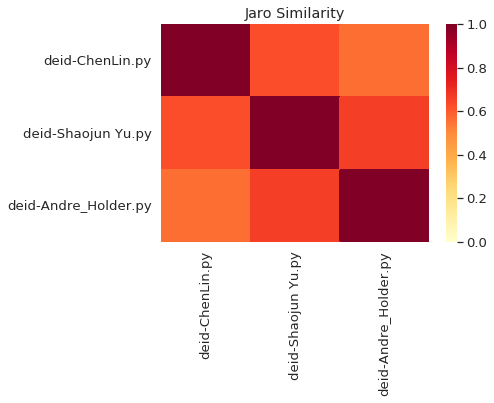

In [40]:
sns.set(font_scale=1.2)
g = sns.heatmap(
    Jaro,
    xticklabels=label,
    yticklabels=label,
    vmin=0,
    vmax=1,
    cmap="YlOrRd")
g.set_xticklabels(label, rotation=90)
g.set_title("Jaro Similarity")

Text(0.5, 1.0, 'Absolute Levenshtein distance')

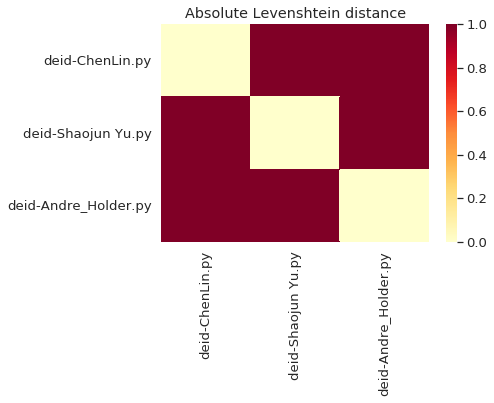

In [50]:
sns.set(font_scale=1.2)
g = sns.heatmap(
    abs_dist,
    xticklabels=label,
    yticklabels=label,
    vmin=0,
    vmax=1,
    cmap="YlOrRd")
g.set_xticklabels(label, rotation=90)
g.set_title("Absolute Levenshtein distance")

Text(0.5, 1.0, 'Jaro-Winkler string similarity')

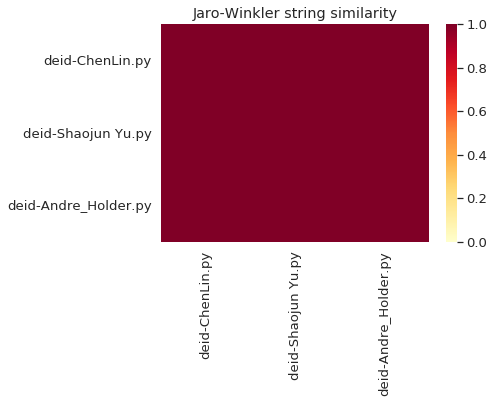

In [51]:
sns.set(font_scale=1.2)
g = sns.heatmap(
    jaro_winkler,
    xticklabels=label,
    yticklabels=label,
    vmin=0,
    vmax=1,
    cmap="YlOrRd")
g.set_xticklabels(label, rotation=90)
g.set_title("Jaro-Winkler string similarity")

Text(0.5, 1.0, 'string similarity')

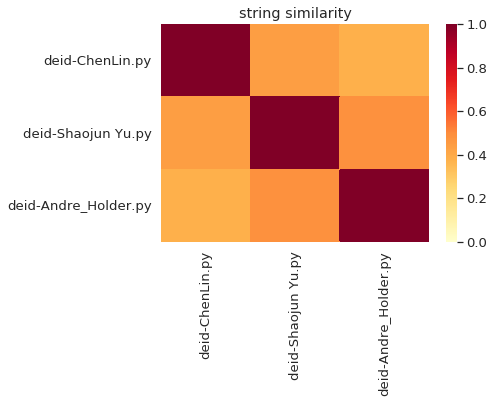

In [47]:
sns.set(font_scale=1.2)
g = sns.heatmap(
    ratio,
    xticklabels=label,
    yticklabels=label,
    vmin=0,
    vmax=1,
    cmap="YlOrRd")
g.set_xticklabels(label, rotation=90)
g.set_title("string similarity")